# Prequesities

In [1]:
import dask.dataframe as dd
import pandas as pd
import dask

import matplotlib
from matplotlib.pyplot import hist
from matplotlib.pyplot import boxplot
import matplotlib.pyplot as plt

%matplotlib inline

import json
import re

In [2]:
version = '0.9.2'
new_version = '0.9.3'

In [3]:
def make_dir_plot(dataframe, limit = 20):
    dir_len_list = list(map(lambda x: len(x),dataframe.directions))
    print(sum(dir_len_list)/len(dir_len_list))
    filtered = list(filter(lambda x: x < limit , dir_len_list))
    print(len(filtered))
    return hist(filtered, bins = range(0,limit+1, limit//20))

def make_ing_plot(dataframe, limit = 20):
    ing_len_list = list(map(lambda x: len(x),dataframe.ingredients))
    print(sum(ing_len_list)/len(ing_len_list))
    filtered = list(filter(lambda x: x < limit , ing_len_list))
    print(len(filtered))
    return hist(filtered, bins = range(0,limit+1, limit//20))

In [4]:
def splitList(inputList: list):
    outputList = list()
    if len(inputList) > 1: # edition splitting only lines length of 1
        return inputList
    for i in inputList:
        outputList.extend(list(map(lambda x: x.strip(), i.split('\n'))))
    return outputList

In [5]:
input_data = ['xdd\n       xdd\nxdd\nxdd']
assert len(splitList(input_data)) == 4

In [6]:
def trim_and_remove_empty_lines(inputList: list):
    result = list(map(lambda x: x.strip(), inputList))
    return list(filter(lambda x: len(x) > 0, result))

In [7]:
test_data = [" "]*15
assert len(trim_and_remove_empty_lines(test_data)) == 0
test_data = [" ", "xD"]
assert len(trim_and_remove_empty_lines(test_data)) == 1

# Read data

In [8]:
df = pd.read_csv('./0-datasets/v-'+version+'-single.csv')
df.describe()

,title,ingredients,directions,link
count,1755013,1755013,1755013,1755013
unique,965216,1731675,1717376,1754626
top,chicken casserole,"[""Zxcvbnm""]",[],https://www.allrecipes.com/recipe/215239/three...
freq,4198,123,417,4


# Explore unicode characters in recipes
* custom handling of sertain characters (e.g. fractions)
* leaving sertain characters as they are
    - degrees sign [link](http://www.fileformat.info/info/unicode/char/b0/index.htm)
* default handling of other characters

In [9]:
test = df.loc[df.ingredients.map(lambda x: "\\u" in x)].iloc[0].ingredients
p = re.compile("\\\\u[0-9A-Fa-f]{4}") # match json parsed unicode characters
p.findall(test)

['\\u00e9']

In [10]:
ing_unicodes = list(filter(lambda x: len(x) > 0, list(df.ingredients.map(lambda x: p.findall(x)))))
dir_unicodes = list(filter(lambda x: len(x) > 0, list(df.directions.map(lambda x: p.findall(x)))))
all_unicodes = ing_unicodes + dir_unicodes
flatten = lambda l: [item for sublist in l for item in sublist]
all_unicodes = flatten(all_unicodes)
print('Distinct unicodes', len(set(all_unicodes)))
print('All unicodes', len(all_unicodes))

Distinct unicodes 1053
All unicodes 2129826


## Parse JSON to list of lines

In [11]:
df.directions = df.directions.map(json.loads).map(trim_and_remove_empty_lines)
df.ingredients = df.ingredients.map(json.loads).map(trim_and_remove_empty_lines)
df.head()

,title,ingredients,directions,link
0,saucy shrimp casserole,"[1/4 c. margarine, 1/4 c. flour, 2 c. milk,...","[Make, cream, sauce, with, margarine, flour, m...",http://www.cookbooks.com/Recipe-Details.aspx?i...
1,no-bake nut cookies,"[1 c. firmly packed brown sugar, 1/2 c. evap...","[In a heavy 2-quart saucepan, mix brown sugar,...",http://www.cookbooks.com/Recipe-Details.aspx?i...
2,jewell ball's chicken,"[1 small jar chipped beef, cut up, 4 boned c...","[Place chipped beef on bottom of baking dish.,...",http://www.cookbooks.com/Recipe-Details.aspx?i...
3,creamy corn,"[2 (16 oz.) pkg. frozen corn, 1 (8 oz.) pkg....","[In a slow cooker, combine all ingredients. Co...",http://www.cookbooks.com/Recipe-Details.aspx?i...
4,chicken funny,"[1 large whole chicken, 2 (10 1/2 oz.) cans ...","[Boil and debone chicken., Put bite size piece...",http://www.cookbooks.com/Recipe-Details.aspx?i...


## Handle unicode characters

In [12]:
replace_list = [
    ('\u2044', '/'),('\u00b0', 'DEGREE_SIGN'),('\u00bd', '1/2'),('\u00bc', '1/4'),
    ('\u00be', '3/4'),('\u00e9', 'e'),('\u2019', "'"),('\u00ae', '(R)'),
    ('\u2013', '-'),('\u00ba', 'DEGREE_SIGN'),('\u00a0', ' '),('\u00f1', 'n'),
    ('\u2153', '1/3'),('\u2152', '1/10'),('\u2151', '1/9'),('\u2150', '1/7'),
    ('\u2154', '2/3'),('\u2155', '1/5'),('\u2156', '2/5'),('\u2157', '3/5'),
    ('\u2158', '4/5'),('\u2159', '1/6'),('\u215a', '5/6'),('\u215b', '1/8'),
    ('\u215c', '3/8'),('\u215d', '5/8'),('\u215e', '7/8'),('\u201d', '"'),
    ('\u2014', '-'),('\u00e8', 'e'),('\u201c', '"'),('\u2033', '"'),
    ('\u2022', ''),('\u00d7', 'x'),('\u00ee', 'i'),('\u2026', '...'),
    ('\u00c2', 'A'),('\u2122', 'TM'),('\u2018', "'"),('\u00ad', '-'),('\u2028', ' '),
]

In [13]:
# example
import unicodedata
t = u"\u2044\u00bd\uf0b7\u00b0\u2013\u00d7\u2028\u00bd\u201c"
print(t)
# https://docs.python.org/3/library/unicodedata.html#unicodedata.normalize
unicodedata.normalize('NFKD', t).encode('ascii','ignore').decode("utf-8")

⁄½°–× ½“


'1212'

In [14]:
# function replaces characters based on list
def replacer(arg: str):
    for k, v in replace_list:
        arg = arg.replace(k, v)
    return arg

In [15]:
def parse_line(line: str):
    line = replacer(line)
    if not line.isascii():
        line = unicodedata.normalize('NFKD', line).encode('ascii','ignore').decode("utf-8")
    # bring back degree sign
    return line.replace('DEGREE_SIGN', '\u00b0')

In [16]:
def parse_list_of_lines(lst: list):
    return list(map(parse_line, lst))

In [17]:
df.ingredients = df.ingredients.map(parse_list_of_lines)
df.directions = df.directions.map(parse_list_of_lines)

## Split directions separated by endline character
In Pandas

5.061236013636366
1740788


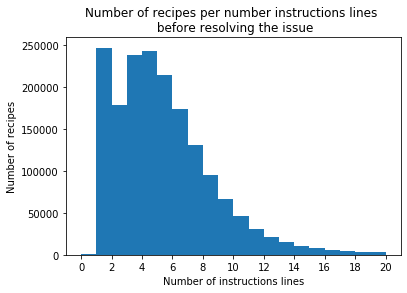

In [18]:
h1 = make_dir_plot(df)
plt.title("Number of recipes per number instructions lines \n before resolving the issue")
plt.ylabel("Number of recipes")
plt.xlabel("Number of instructions lines")
plt.xticks(list(range(0,21,2)))
plt.savefig('dir-frequency-before.png')

In [19]:
# split directions
df.directions = df.directions.map(splitList)
df.ingredients = df.ingredients.map(splitList)

5.3066934546923585
1738554


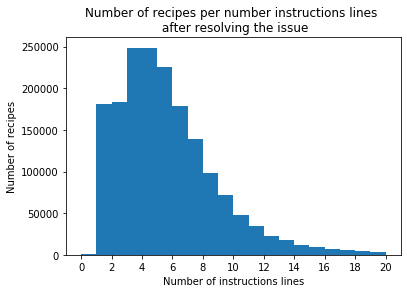

In [20]:
h2 = make_dir_plot(df)
plt.title("Number of recipes per number instructions lines \n after resolving the issue")
plt.ylabel("Number of recipes")
plt.xlabel("Number of instructions lines")
plt.xticks(list(range(0,21,2)))
plt.savefig('dir-frequency-after.png')

## Drop test recipes

In [21]:
df.loc[df.title == 'test']

,title,ingredients,directions,link
1439850,test,[138 grams test],[canceled],https://food52.com/recipes/73656-test
1441682,test,"[ssklfjsf, 1 teaspoon salt, 2 bunches bread, k...","[cook whatever, sdflkjasdf]",https://food52.com/recipes/22121-test
1449857,test,"[1 test, 1 test, 1 test]","[jvghjfcvhcm, hgj,gu,]",https://food52.com/recipes/32281-test
1452659,test,[1 cup test],[test],https://food52.com/recipes/77156-test
1453521,test,[1 test],[test],https://food52.com/recipes/54987-test
1465618,test,[2 cups food],[test],https://food52.com/recipes/77155-test
1466138,test,[1 cup test],[test],https://food52.com/recipes/20978-test
1470427,test,"[test1, 1 cup test, test2, 2 cups test]","[test, test]",https://food52.com/recipes/27743-test
1470505,test,"[test, 1 handful test, test2, 1 dash 1]",[just for testing purposes.],https://food52.com/recipes/11621-test
1475231,test,[1 1],[1],https://food52.com/recipes/33019-test


In [22]:
# pandas
df = df.drop(df.loc[df.title == 'test'].index)

## Filter out recipes without instructions or ingredients

In [23]:
df = df.loc[df.directions.map(len) > 0]
df = df.loc[df.ingredients.map(len) > 0]

## Dealing with single word instructions

In [24]:
list(df[df.index == 0].link)

['http://www.cookbooks.com/Recipe-Details.aspx?id=619430']

In [25]:
print("Title:\t", df.iloc[0].title)
print("Ingredients:\t", df.iloc[0].ingredients)
print("Dricetions:\t", df.iloc[0].directions)
print("Link:\t", df.iloc[0].link)

Title:	 saucy shrimp casserole
Ingredients:	 ['1/4  c. margarine', '1/4  c. flour', '2  c. milk', '1  tsp. salt', '1/2  tsp. Worcestershire sauce', 'dash of pepper', '8  oz. Cracker Barrel cheese, shredded', '6  hard boiled eggs', '1  lb. cooked shrimp']
Dricetions:	 ['Make', 'cream', 'sauce', 'with', 'margarine, flour, milk, salt, Worcestershire', 'sauce', 'and\tdash', 'of pepper.', 'Add cheese; stir until', 'melted.', 'Alternate', 'layers of hard boiled eggs (sliced) cooked', 'shrimp,', 'and', 'cheese', 'sauce', 'in 1 1/2 quart casserole. Bake 20 to 25 minutes at 350°.']
Link:	 http://www.cookbooks.com/Recipe-Details.aspx?id=619430


In [26]:
def find_single_word_directions(directions: list):
    total_spaces = 0
    for d in directions:
        total_spaces += d.count(' ')
    if total_spaces/len(directions) > 2:
        return False
    return True
    

In [27]:
find_single_word_directions(df[df.index == 0].directions)

True

In [28]:
s = df.directions.map(find_single_word_directions).astype('bool')

In [29]:
sum(list(s))

26830

If the function is right, there is less then 30k recipes with single word instructions. It will be easiest to drop them.

In [30]:
df = df.drop(df.loc[df.directions.map(find_single_word_directions)].index)

## Apply title key

In [31]:
df.loc[df.title.map(lambda x: x == x.lower())].count()

title          932691
ingredients    932691
directions     932691
link           932691
dtype: int64

In [32]:
df.title = df.title.map(lambda x: x.title())

## Drop recipes with ambigious title

In [33]:
df.loc[df.title.map(lambda x: x == x.lower())]

,title,ingredients,directions,link
941614,2-2-2,"[2 lb. stew beef cubes, 2 cans cream of mush...",[Mix all ingredients together in a crock-pot i...,http://www.cookbooks.com/Recipe-Details.aspx?i...
1092397,747,"[1 ounce vodka, 1 ounce Rose's lim...",[Build in a highball glass.],https://www.food.com/recipe/747-260750
1336448,泡芙酱/北海道酱,"[10 Egg yolk, 200 g Sugar, 1000 g Milk, 50 g ...","[Heat milk, butter and half of the sugar till ...",https://www.epicurious.com/recipes/member/view...
1353919,فتة مصرية بالخل والثوم,"[1 kg , 2 loaves , 1/2 kg , 1 head , 6...","[ , , , ,...",https://www.epicurious.com/recipes/member/view...
1385616,آموزش ساخت ربات اینستاگرام,[5 2/3 cup],"[combine egg with water...., then put water in...",https://www.epicurious.com/recipes/member/view...
1390344,,"[Ingredients:, 2 teaspoons coconut oil, 1/2 ...","[Directions:, , 1. Heat oil in a medium sauce ...",https://www.epicurious.com/recipes/member/view...
1404938,龙水,"[3 ounces Vodka (preferably citrus flavored), ...","[Combine ingredients in a glass, Serve over ice]",https://www.epicurious.com/recipes/member/view...
1415925,水果蛋糕,[(1)[url=http://www.wholesales-nike-shoes.com]...,[:[url=http://www.shopping-trends.com]cheap ni...,https://www.epicurious.com/recipes/member/view...
1417832,مسقعة قرنبيط,"[1 bunch 1. , 1 bunch 2. , 1 bunch 3. , 1 bun...","[1. 10 , 2. , 3. 11 13 , ...",https://www.epicurious.com/recipes/member/view...
1424237,,"[Muslos de pollo con hueso, Sal, pimienta, tom...","[Se lava el pollo muy bien y se seca., En un s...",https://www.epicurious.com/recipes/member/view...


In [34]:
df = df.loc[df.title.map(lambda x: x != x.lower())]

# Remove extra spaces in middle text

In [35]:
def inner_space_removal(input_list: list):
    t = json.dumps(input_list)
    t = t.replace('\\\n', ' ')
    t = t.replace('\\\t', ' ')
    while t.find('  ') >= 0:
        t = t.replace('  ', ' ')
    return json.loads(t)

In [36]:
df.ingredients = df.ingredients.map(inner_space_removal)
df.directions = df.directions.map(inner_space_removal)

# Calculate statistics

In [37]:
def get_domain(url: str) -> str:
    w = url.split('//')[1]
    return w.split('/')[0]

assert get_domain('http://food.com/recipes') == 'food.com'

In [38]:
source = df.link.map(get_domain)
ingredients_count = df.ingredients.map(len)
directions_count = df.directions.map(len)
df.insert(4, 'source', source)
df.insert(5, "ingredients_count", ingredients_count)
df.insert(6, "directions_count", directions_count)

In [39]:
df.groupby(["source"]).agg({
    'title': 'count',
    'ingredients_count': ['min', 'mean', 'max'],
    'directions_count': ['min', 'mean', 'max']
})

title ingredients_count                  \
                      count               min       mean  max   
source                                                          
food52.com            49354                 1  11.087673   49   
recipes-plus.com      20567                 1  10.001605   48   
tastykitchen.com      51331                 1  10.122265   45   
www.allrecipes.com    62021                 1   9.277841   52   
www.cookbooks.com    931071                 1   7.485713  407   
www.epicurious.com   102193                 1  10.019855   82   
www.food.com         294735                 1   9.713163   50   
www.myrecipes.com     69736                 1   9.591947   44   
www.seriouseats.com   26674                 1  10.435368   49   
www.tasteofhome.com   54435                 1  10.008524   36   
www.yummly.com        65529                 1   9.516870   62   

                    directions_count                 
                                 min      mean  max  
source                                               
food52.com                         1  5.664100   55  
recipes-plus.com                   1  3.453785   12  
tastykitchen.com                   1  5.422454   48  
www.allrecipes.com                 1  3.406411   27  
www.cookbooks.com                  1  5.066922   71  
www.epicurious.com                 1  5.787637   89  
www.food.com                       1  6.901040  107  
www.myrecipes.com                  1  3.470044   42  
www.seriouseats.com                1  4.556609   40  
www.tasteofhome.com                1  2.712850   34  
www.yummly.com                     1  4.966976   56

In [40]:
df.agg({
    'title': 'count',
    'ingredients_count': ['min', 'mean', 'max'],
    'directions_count': ['min', 'mean', 'max']
})

,title,ingredients_count,directions_count
count,1727646.0,NaN,NaN
max,NaN,407.000000,107.000000
mean,NaN,8.578222,5.220961
min,NaN,1.000000,1.000000


In [41]:
df = df.drop(columns = ['source', 'ingredients_count', 'directions_count'])
df.columns

Index(['title', 'ingredients', 'directions', 'link'], dtype='object')

# Store tuned dataset

In [42]:
df.to_json('0-datasets/v-' + new_version + '-single.json')

In [43]:
df.ingredients = df.ingredients.map(json.dumps)
df.directions = df.directions.map(json.dumps)

In [44]:
df.to_csv('0-datasets/v-' + new_version + '-single.csv', index=False)